# MSOA admissions prediction

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
data = pd.read_csv('./data/msoa_collated.csv', index_col='MSOA')

# Limit to England data
mask = data['country'] == 'E'
data = data[mask]
data = data.drop('country', axis=1)
data = data.drop('All persons', axis=1)

data.head()

,admissions,IMD2019Score,0-64,65-79,80+
MSOA,,,,,
Adur 001,14.333333,16.924833,6905.0,1339.0,571.0
Adur 002,7.333333,6.470400,5431.0,1345.0,487.0
Adur 003,9.333333,13.733400,5745.0,1157.0,452.0
Adur 004,21.000000,26.199857,8583.0,1371.0,628.0
Adur 005,13.666667,11.794800,6995.0,1479.0,585.0


### Split into X and y

In [3]:
X = data.drop('admissions', axis=1)
y = data['admissions']

## Create k-fold splits

In [4]:
# Set up splits
number_of_splits = 6
skf = KFold(n_splits = number_of_splits, shuffle=True, random_state=42)
X_fields = list(X)
X = X.values
y = y.values
skf.get_n_splits(X, y)

6

## Linear regression

In [5]:
r_square_results = []
observed = []
predictions = []
coefficients = []

# Loop through the k-fold splits
for train_index, test_index in skf.split(X, y):

    # Get X and Y train/test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    observed.append(y_test)

    # Fit model
    model = LinearRegression().fit(X_train, y_train)

    # get predictions
    y_pred = model.predict(X_test)
    predictions.append(y_pred)
    r_square = metrics.r2_score(y_test, y_pred)
    r_square_results.append(r_square)
    coefficients.append(model.coef_)
    
mean_r_square = np.mean(r_square_results)
sem = np.std(r_square_results) / number_of_splits ** 0.5
print (f'Mean r-squared (sem): {mean_r_square:0.3f} ({sem:0.3f})') 


Mean r-squared (sem): 0.611 (0.009)


In [6]:
mean_coefficients = np.mean(coefficients, axis=0)
mean_coefficients

array([0.1257839 , 0.00026394, 0.00361699, 0.01439254])

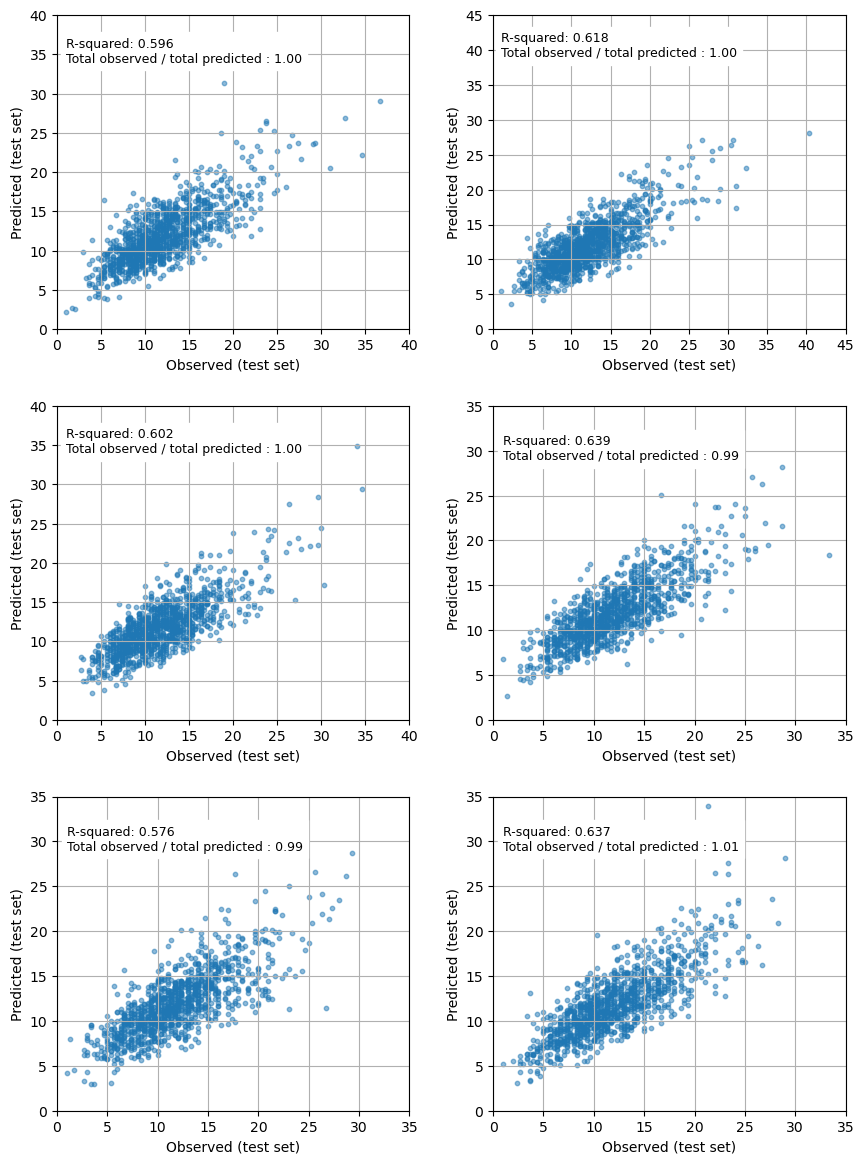

In [7]:
fig = plt.figure(figsize=(9,12))

for k in range (number_of_splits):

    ax = fig.add_subplot(3,2,k+1)


    max_val = np.max([np.max(observed[k]), np.max(predictions[k])]) + 1
    max_val = 5 + (int(max_val/5)*5)

    ratio = np.sum(observed[k]) / np.sum(predictions[k])

    ax.scatter(observed[k], predictions[k], s=10, alpha=0.5)

    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.grid()
    ax.set_xlabel('Observed (test set)')
    ax.set_ylabel('Predicted (test set)')
    ticks = np.arange(0,max_val+1, 5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    text = (f'R-squared: {r_square_results[k]:0.3f}\n' +
            f'Total observed / total predicted : {ratio:0.2f}')
    ax.text(1, max_val-6, text, backgroundcolor='1.0', fontsize=9)

plt.tight_layout(pad=2)
plt.show()

## Make predictions for England and Wales

In [8]:
data = pd.read_csv('./data/msoa_collated.csv', index_col='MSOA')

#Train model on all England data
mask = data['country'] == 'E'
X_train = data[mask]
y_train = data[mask]['admissions']
X_train = X_train[X_fields]

# Fit model and get admissions
model = LinearRegression().fit(X_train, y_train)
predictions = model.predict(data[X_fields])
predicted_admissions = pd.DataFrame(
    predictions, columns=['predicted admissions'], index=data.index)
    
# Get MSOA for each LSOA
lsoa_msoa = pd.read_csv('./data/lsoa_to_msoa.csv')
lsoa_msoa['count'] = 1
lsoa_counts = lsoa_msoa.groupby('msoa11nm').sum()


In [9]:
# Create dataframe with admissions per MSOA and number of LSOA per MSOA
predicted_admissions = \
    pd.merge(predicted_admissions, lsoa_counts, left_index=True, right_index=True, how='left')

# Calculate the number of admissions for LSOA in each MSOA
predicted_admissions['LSOA_predicted_admissions'] = \
    predicted_admissions['predicted admissions'] / predicted_admissions['count']

# Add predictions per LSOA to all LSOAs
lsoa_predictions = pd.merge(
    lsoa_msoa, predicted_admissions, left_on='msoa11nm', right_index=True, how='left')

# Clean table
cols = ['lsoa11cd', 'lsoa11nm', 'msoa11cd', 'msoa11nm', 'country', 'LSOA_predicted_admissions']
lsoa_predictions = lsoa_predictions[cols]

mask = (lsoa_predictions['country'] == 'E' ) | (lsoa_predictions['country'] == 'W')
lsoa_predictions = lsoa_predictions[mask]


lsoa_predictions.head()

,lsoa11cd,lsoa11nm,msoa11cd,msoa11nm,country,LSOA_predicted_admissions
0,E01000001,City of London 001A,E02000001,City of London 001,E,1.883052
1,E01000002,City of London 001B,E02000001,City of London 001,E,1.883052
2,E01000003,City of London 001C,E02000001,City of London 001,E,1.883052
3,E01000005,City of London 001E,E02000001,City of London 001,E,1.883052
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E,1.713104


In [10]:
lsoa_predictions.to_csv('outputs/lsoa_predicted_admissions.csv', index=False)